# Ask questions about how many linear ops there are

## Authors:
- **David W. Hogg** (NYU) (MPIA) (Flatiron)
- **Soledad Villar** (JHU)

## To-do items and bugs:
- Do something.

In [1]:
import sys
sys.path.insert(0,'../src/geometricconvolutions/')

In [2]:
import itertools as it
import numpy as np
import geometric as geom
import utils
import finufft
import pylab as plt
%load_ext autoreload
%autoreload 2

In [3]:
D = 2
group_operators = geom.make_all_operators(D)
print(len(group_operators))

8


In [4]:
allfilters = {}
names = {}
maxn = {}
for M in [3, ]:
    maxn[(D, M)] = 0
    klist = (0, 1, 2)
    for k, parity in it.product(klist, (0, 1)):
        key = (D, M, k, parity)
        allfilters[key] = geom.get_unique_invariant_filters(M, k, parity, D, group_operators)
        n = len(allfilters[key])
        if n > maxn[(D, M)]:
            maxn[(D, M)] = n
        names[key] = ["{} {}".format(geom.tensor_name(k, parity), i) for i in range(n)]

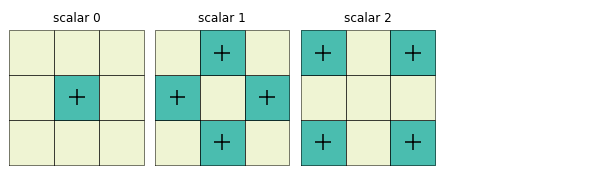

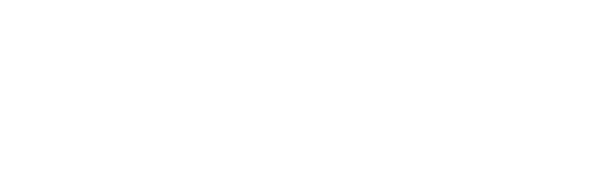

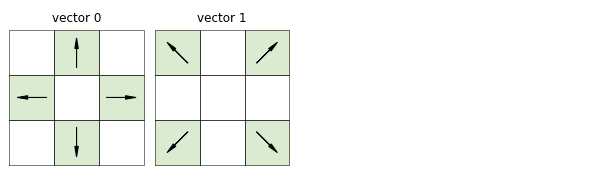

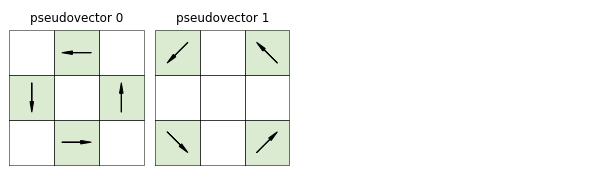

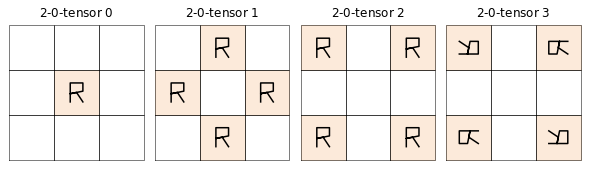

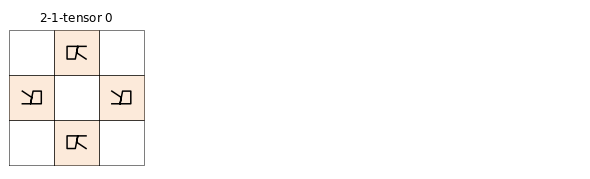

In [5]:
for key in allfilters.keys():
    D, M, k, parity = key
    fig = utils.plot_filters(allfilters[key], names[key], maxn[(D, M)])

In [6]:
# Make a sensible vector image on a D-torus
N = 3
np.random.seed(42)
if D == 2:
    imagex = np.random.normal(size=(N, N))
    imagey = np.random.normal(size=(N, N))
    package = np.zeros((N, N, D))
    filtered = False # True if you want the image to be "smooth".
    if filtered:
        foo = np.pi * np.arange(-1. + 1. / N, 1., 2. / N)
        ys, xs = np.meshgrid(foo, foo) # ys, xs or xs, ys??
        ftx = finufft.nufft2d1(xs.flatten(), ys.flatten(), imagex.flatten().astype(complex), (12, 12))
        fty = finufft.nufft2d1(xs.flatten(), ys.flatten(), imagey.flatten().astype(complex), (12, 12))
        package[:, :, 0] = finufft.nufft2d2(xs.flatten(), ys.flatten(), ftx).reshape(N, N).real
        package[:, :, 1] = finufft.nufft2d2(xs.flatten(), ys.flatten(), fty).reshape(N, N).real
    else:
        package[:, :, 0] = imagex
        package[:, :, 1] = imagey
if D == 3:
    package = np.random.normal(size=(N, N, N, D))
package /= np.sqrt(np.mean(package ** 2))
print(package.shape)
vector_image = geom.GeometricImage(package, 0, D).normalize()
print(vector_image)

(3, 3, 2)
<<class 'geometric.GeometricImage'> object in D=2 with N=3, k=1, and parity=0>


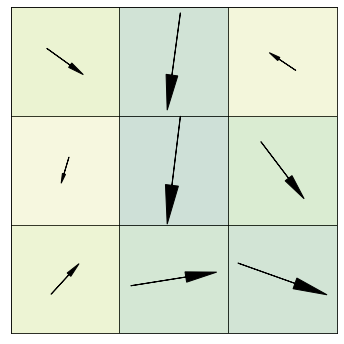

In [7]:
if D == 2:
    fig = utils.plot_image(vector_image)

In [8]:
# How can we make a vector image from this vector image?
# 1. Convolve with scalar filters
M = 3
key = (D, M, 0, 0) # D M k parity
v_images = [vector_image.convolve_with(ff).normalize() for ff in allfilters[key]]
print(len(v_images))

3


In [9]:
# 2. Convolve with pseudoscalar filters and Levi-Civita contract
# Oh wait, we don't have any pseudoscalars at 3x3!
key = (D, M, 0, 1) # D M k parity
v_images += [vector_image.convolve_with(ff).levi_civita_contract(0).normalize() for ff in allfilters[key]]
print(len(v_images))

3


In [10]:
# 3. Convolve with 2-tensor filters and contract
key = (D, M, 2, 0) # D M k parity
v_images += [vector_image.convolve_with(ff).contract(0, 1).normalize() for ff in allfilters[key]]
v_images += [vector_image.convolve_with(ff).contract(0, 2).normalize() for ff in allfilters[key]]
print(len(v_images))

11


In [11]:
# 4.A Convolve with 2-pseudotensor filters, Levi-Civita contract, and contract
if D == 2:
    key = (D, M, 2, 1) # D M k parity
    v_images += [vector_image.convolve_with(ff).levi_civita_contract(0).contract(0, 1).normalize() for ff in allfilters[key]]
    v_images += [vector_image.convolve_with(ff).levi_civita_contract(0).contract(0, 2).normalize() for ff in allfilters[key]]
    print(len(v_images))

13


In [12]:
# 4.B Convolve with pseudovector filters, Levi-Civita contract (ie, cross product!)
if D == 3:
    key = (D, M, 1, 1) # D M k parity
    v_images += [vector_image.convolve_with(ff).levi_civita_contract([0, 1]).normalize() for ff in allfilters[key]]
    print(len(v_images))

In [13]:
datablock = np.array([im.data.flatten() for im in v_images])
print(datablock.shape)
u, s, v = np.linalg.svd(datablock)
print("there are", np.sum(s > geom.TINY), "different images")

(13, 18)
there are 5 different images


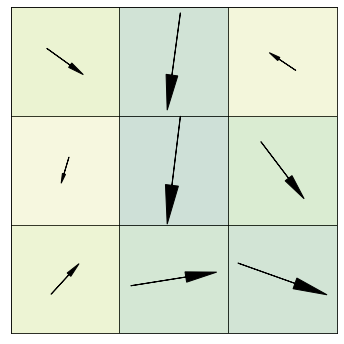

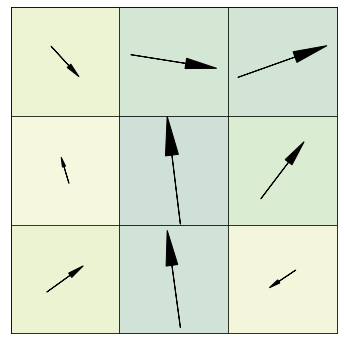

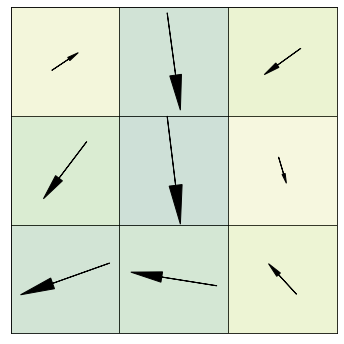

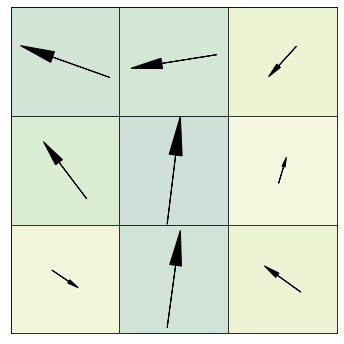

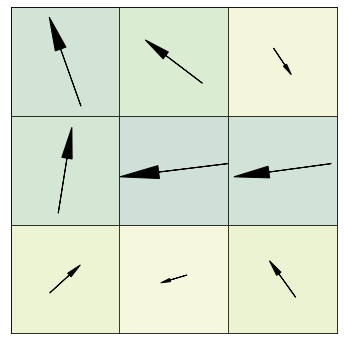

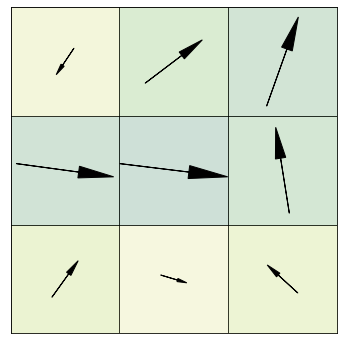

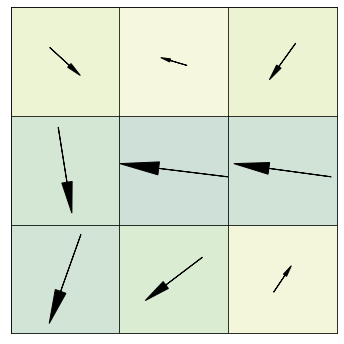

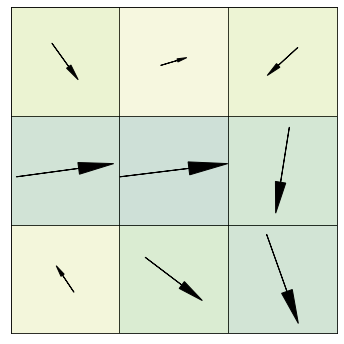

In [22]:
first_func = v[0].reshape((3,3,2))
for op in group_operators:
    utils.plot_image(vector_image.times_group_element(op))